In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 

import torch
from torch import nn 

torch.__version__

'1.13.1'

## 02 Neural Network Classification with PyTorch

### Making classification data and getting it ready

In [2]:
import sklearn
from sklearn.datasets import make_circles

n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

len(X), len(y)

(1000, 1000)

In [3]:
print(f"First 5 sampels of X: \n\n{X[:5]}")
print()
print(f"First 5 sampels of y: {y[:5]}")

First 5 sampels of X: 

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 sampels of y: [1 1 1 1 0]


In [4]:
# Make DataFrame of circle data
circles = pd.DataFrame({
    "X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})

circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


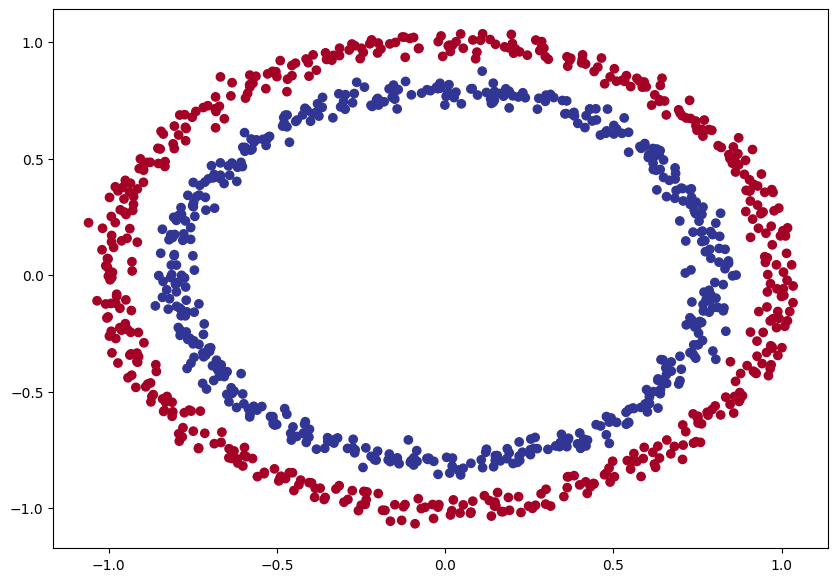

In [5]:
plt.figure(figsize=(10, 7))

plt.scatter(circles.iloc[:, 0], circles.iloc[:, 1], c=circles.iloc[:, 2], cmap=plt.cm.RdYlBu)
plt.show()

### Check input and output shapes

In [6]:
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
# View the first examples of features and labels
x_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {x_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {x_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### Turn data into train and test splits

In [8]:
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [9]:
# Split data into different datasets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=32
)

len(X_train), len(X_test)

(800, 200)

In [10]:
n_samples

1000

### Building a model

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [12]:
class CircleModelV0(nn.Module):

    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.relu1 = nn.ReLU()
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
        
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.layer_2(
            self.relu1(
            self.layer_1(x)
            )
        )
    
model_0 = CircleModelV0().to(device=device)

In [13]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [14]:

model_0_1 = nn.Sequential(
nn.Linear(in_features=2, out_features=5),
nn.ReLU(),
nn.Linear(in_features=5, out_features=1),
).to(device)

model_0_1

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.4597, -0.3631],
                      [ 0.1394,  0.1254],
                      [ 0.1117,  0.5768],
                      [ 0.6191,  0.2332],
                      [ 0.1572,  0.2617]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.0128, -0.3334, -0.1662, -0.2687, -0.0165], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.1783,  0.1291, -0.1770,  0.4176,  0.0608]], device='cuda:0')),
             ('layer_2.bias', tensor([0.3299], device='cuda:0'))])

In [16]:
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
    print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
    print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
    print(f"\n First 10 predictions:\n{untrained_preds[:10]}")
    print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

 First 10 predictions:
tensor([[0.4267],
        [0.2897],
        [0.3815],
        [0.3915],
        [0.4032],
        [0.3386],
        [0.3915],
        [0.4137],
        [0.4253],
        [0.3908]], device='cuda:0')

First 10 labels:
tensor([0., 1., 0., 0., 1., 0., 1., 0., 1., 1.])


### Loss function and optimizer

In [17]:
loss_fn = nn.BCEWithLogitsLoss() # contains a sigmoid activation function build in and binary cross entropy. THis is more numerically stable than using a plane sigmoid function and a BCELOSS

# e.g
# nn.Sequential(nn.Sigmoid(), nn.BCELoss()) = nn.BCEWithLogitsLoss()

#There is also another one called BCELoss which is just a binary cross entropy, which input requires the output from a sigmoid function 

In [18]:
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.001)

### Calculating Accuracy

In [19]:
# Accuracy metrics
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = ( correct / len(y_pred) ) * 100
    return acc

### Train Model

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss Backward (BAckPropagation)
5. Optimizer step (gradient descent)

Our raw outputs from the model are called logits. These logits is then passed to an activation function for getting the classes.

In [20]:
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (relu1): ReLU()
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [21]:
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.4267],
        [0.2897],
        [0.3815],
        [0.3915],
        [0.4032]], device='cuda:0')

In [22]:
#Using the sigmoid activation function to get prediction probabilities
y_pred_props = torch.sigmoid(y_logits)
y_pred_props

tensor([[0.6051],
        [0.5719],
        [0.5942],
        [0.5967],
        [0.5995]], device='cuda:0')

In [23]:
torch.round(y_pred_props)

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')

### Building training and testing loops

In [24]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    #training
    model_0.train()

    #1. forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    #Calculate loss & accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_pred=y_pred, y_true=y_train)

    # OPtimier zero grad
    optimizer.zero_grad()

    # Loss backward (backpropagation)
    loss.backward()

    # Optimizer step (gradient descent)
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # calculate loss and acc
        test_loss =  loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_pred=test_pred, y_true=y_test)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 0.71468, Acc: 50.12 | Test loss: 0.71857 | Test acc: 49.50
Epoch: 10 | Loss: 0.71458, Acc: 50.12 | Test loss: 0.71846 | Test acc: 49.50
Epoch: 20 | Loss: 0.71447, Acc: 50.12 | Test loss: 0.71835 | Test acc: 49.50
Epoch: 30 | Loss: 0.71436, Acc: 50.12 | Test loss: 0.71824 | Test acc: 49.50
Epoch: 40 | Loss: 0.71426, Acc: 50.12 | Test loss: 0.71813 | Test acc: 49.50
Epoch: 50 | Loss: 0.71415, Acc: 50.12 | Test loss: 0.71802 | Test acc: 49.50
Epoch: 60 | Loss: 0.71404, Acc: 50.12 | Test loss: 0.71791 | Test acc: 49.50
Epoch: 70 | Loss: 0.71394, Acc: 50.12 | Test loss: 0.71780 | Test acc: 49.50
Epoch: 80 | Loss: 0.71384, Acc: 50.12 | Test loss: 0.71769 | Test acc: 49.50
Epoch: 90 | Loss: 0.71373, Acc: 50.12 | Test loss: 0.71759 | Test acc: 49.50


### 4. Make predictions and evalute the model

In [25]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.
    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

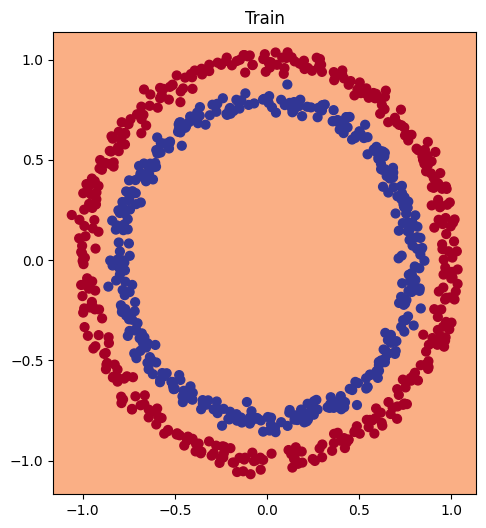

In [26]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")

plot_decision_boundary(model_0, X_train, y_train)

### Improving the model

You can add
* more layers
* more hidden units
* Fit for longer
* Changing the activation functions
* CHange the learning rate
* CHange the loss function

In [27]:
class CircleModelV1(nn.Module):

    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.relu_1 = nn.ReLU()
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.relu_2 = nn.ReLU()
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        x = self.layer_1(x)
        x = self.relu_1(x)
        x = self.layer_2(x)
        x = self.relu_2(x)
        x = self.layer_3(x)
        return x
    
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (relu_1): ReLU()
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (relu_2): ReLU()
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [28]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),lr=0.001)

epochs = 1000

# X_train, y_train = X_train.to(device), y_train.to(device)
# X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    #training
    model_1.train()

    #1. forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    #Calculate loss & accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_pred=y_pred, y_true=y_train)

    # OPtimier zero grad
    optimizer.zero_grad()

    # Loss backward (backpropagation)
    loss.backward()

    # Optimizer step (gradient descent)
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # calculate loss and acc
        test_loss =  loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_pred=test_pred, y_true=y_test)

    if (epoch+1) % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}")

Epoch: 99 | Loss: 0.68323, Acc: 55.00 | Test loss: 0.68971 | Test acc: 48.50
Epoch: 199 | Loss: 0.65997, Acc: 61.75 | Test loss: 0.67876 | Test acc: 52.50
Epoch: 299 | Loss: 0.61411, Acc: 73.50 | Test loss: 0.64517 | Test acc: 65.50
Epoch: 399 | Loss: 0.52400, Acc: 86.00 | Test loss: 0.55473 | Test acc: 80.50
Epoch: 499 | Loss: 0.40799, Acc: 95.75 | Test loss: 0.43634 | Test acc: 92.50
Epoch: 599 | Loss: 0.29297, Acc: 98.38 | Test loss: 0.32161 | Test acc: 97.50
Epoch: 699 | Loss: 0.20320, Acc: 99.12 | Test loss: 0.23443 | Test acc: 98.00
Epoch: 799 | Loss: 0.14831, Acc: 99.62 | Test loss: 0.17610 | Test acc: 99.50
Epoch: 899 | Loss: 0.11274, Acc: 99.88 | Test loss: 0.13326 | Test acc: 100.00
Epoch: 999 | Loss: 0.08832, Acc: 99.75 | Test loss: 0.10417 | Test acc: 100.00


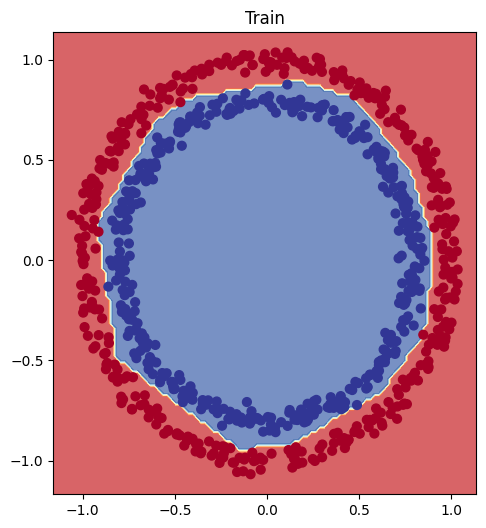

In [29]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")

plot_decision_boundary(model_1, X_train, y_train)

### Evaluating trained model

In [37]:
next(model_1.parameters()).device

device(type='cpu')

In [39]:
model_1.eval()
with torch.inference_mode():
    model_1 = model_1.to(device)
    pred_props = model_1(X_test).squeeze()
    y_preds = torch.round( torch.sigmoid(pred_props) )

y_preds[:5], y_test[:5]

(tensor([0., 1., 0., 0., 1.], device='cuda:0'),
 tensor([0., 1., 0., 0., 1.], device='cuda:0'))

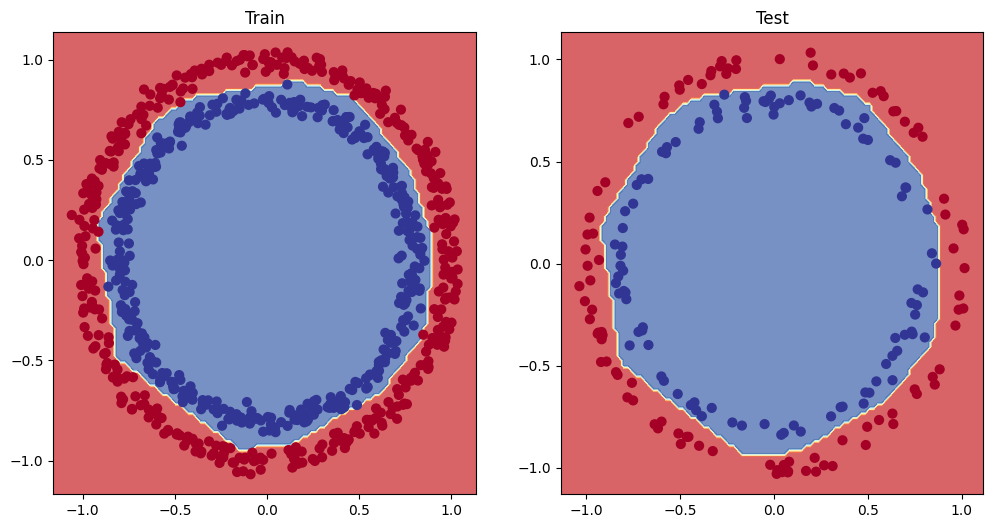

In [40]:
plt.figure(figsize=(12, 6))

plt.subplot(1,2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)